# Generación de topicos y clasificación de textos según estos

El código utilizado para generar lo tópicos y clasificar los artículos es basado en el artículo [Topic Modelling in Python with spaCy and Gensim](https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf)

In [58]:
# Librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import nltk
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from tqdm import tqdm
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()#

In [59]:
# Importar documento a procesar
df = pd.read_csv('../data/curated/curated_database.csv', encoding='utf-8-sig', index_col=[0])

In [60]:
# Hasta el momento la única columna procesada ha sido el Contenido
columna = 'Contenido'
df[f'{columna} lematizado'] = df[f'{columna} lematizado'].apply(lambda x: x.replace('[', '').replace(']', '').replace('\'', '').split(','))
dictionary = Dictionary(df[f'{columna} lematizado'])
# Filtrar los tokens de baja y alta frecuencia. Limitar el vocabulario 
# a un máximo de 100 palabras
dictionary.filter_extremes(no_below=5, no_above=0.5)
# Contar el número de ocurrencias de cada palabra única
corpus = [dictionary.doc2bow(doc) for doc in df[f'{columna} lematizado']]

La puntuación de coherencia de C_v oscila entre 0 (incoherencia total) y 1 (coherencia total). Los valores superiores a 0,5 son bastante buenos, según John McLevey (fuente: Doing Computational Social Science: A Practical Introduction By John McLevey). Por otro lado, C_umass devuelve valores negativos.

In [6]:
# Método de Pareto (relajado para romper cuando cambie de dirección)
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=1, workers = 4, passes=10, random_state=100)
top_ant = 1
top_act = None

cm_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass').get_coherence()
score_ant = cm_umass.get_coherence()
score_act = None

for i in tqdm(range(2,21,1)):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   top_act = i
   cm_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   score_act = cm_umass.get_coherence()
   m = score_act - score_ant
   if m >= 0:
      break
   top_ant = i
   score_ant = score_act
   
top_ant

  5%|▌         | 1/19 [01:17<23:22, 77.94s/it]


2

In [18]:
# Calcular la coherencia C_umass, C_v y número de topicos
topics = []
score_umass = []
score_v = []
for i in tqdm(range(1,20,1)):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   cm_v = CoherenceModel(model=lda_model, texts = df[f'{columna} lematizado'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score_umass.append(cm_umass.get_coherence())
   score_v.append(cm_v.get_coherence())

100%|██████████| 19/19 [24:07<00:00, 76.18s/it]


In [22]:
# Valor mas a la izquierda que este entre el valor minimo + 0.2
min_score = min(score_umass)
indice = score_umass.index(min_score)
for i in range(len(score_umass)):
    if score_umass[i] - 0.2 <= min_score:
        break
i

11

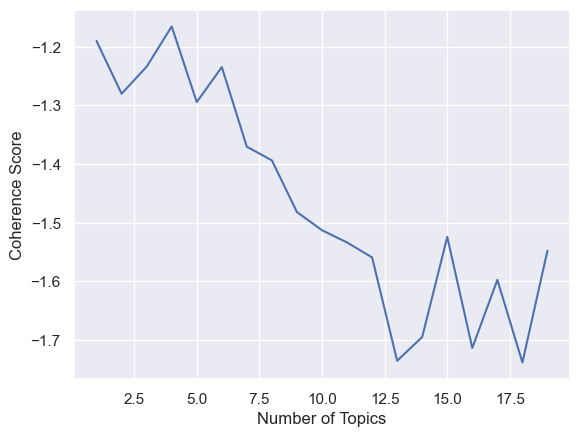

In [10]:
# Visualizar la coherencia C_umass vs número topicos
_=plt.plot(topics, score_umass)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

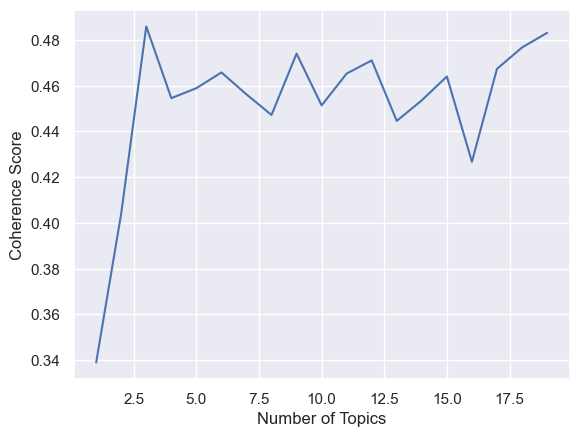

In [11]:
# Visualizar la coherencia C_v vs número topicos
_=plt.plot(topics, score_v)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [12]:
# númeor de iteraciones 50 por defecto
# workers equivale al número de cores del computador
# passes número de veces que pasa por el corpus para entrenarse
lda_model_8 = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=8, workers=4, passes=10)
lda_model_16 = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=16, workers=4, passes=10)

In [13]:
lda_model_8.print_topics(-1)

[(0,
  '0.014*" millón" + 0.013*" banco" + 0.008*" empresa" + 0.008*" financiero" + 0.008*" tasa" + 0.008*" crédito" + 0.007*" billón" + 0.007*" colombia" + 0.007*" pago" + 0.006*" tarjeta"'),
 (1,
  '0.007*" mujer" + 0.005*" petro" + 0.005*" empresa" + 0.005*" año" + 0.004*" daes" + 0.004*" colombia" + 0.004*" partido" + 0.004*" social" + 0.004*" público" + 0.004*" programa"'),
 (2,
  '0.006*" maestro" + 0.005*" educación" + 0.005*" año" + 0.004*" bogotá" + 0.003*" estudiante" + 0.003*" social" + 0.003*" niño" + 0.003*" docente" + 0.003*" público" + 0.003*" calle"'),
 (3,
  '0.007*" año" + 0.005*" tiempo" + 0.005*" mujer" + 0.004*" historia" + 0.004*" mundo" + 0.004*" hombre" + 0.004*" vida" + 0.004*" película" + 0.004*" leer" + 0.004*" momento"'),
 (4,
  '0.019*" ecopetrol" + 0.010*" gobierno" + 0.010*" presidente" + 0.008*" acción" + 0.008*" empresa" + 0.007*" junta" + 0.007*" colombia" + 0.006*" compañía" + 0.006*" petro" + 0.005*" bayón"'),
 (5,
  '0.012*" empresa" + 0.010*" país"

In [14]:
lda_model_16.print_topics(-1)

[(0,
  '0.012*" inflación" + 0.010*" precio" + 0.007*" tasa" + 0.007*" crecimiento" + 0.006*" colombia" + 0.006*" alza" + 0.006*" dólar" + 0.006*" alimento" + 0.005*" económico" + 0.005*" aumento"'),
 (1,
  '0.006*" tiempo" + 0.005*" millón" + 0.005*" colombia" + 0.005*" colombiano" + 0.004*" servicio" + 0.004*" momento" + 0.004*" año" + 0.004*" pasar" + 0.004*" usuario" + 0.004*" canción"'),
 (2,
  '0.014*" gobierno" + 0.012*" petro" + 0.008*" presidente" + 0.008*" político" + 0.006*" silla" + 0.006*" política" + 0.004*" partido" + 0.004*" gustavo" + 0.004*" cambio" + 0.003*" congreso"'),
 (3,
  '0.010*" empresa" + 0.007*" servicio" + 0.006*" punto" + 0.005*" licitación" + 0.005*" mercado" + 0.005*" público" + 0.005*" decisión" + 0.004*" gobierno" + 0.004*" millón" + 0.004*" seguir"'),
 (4,
  '0.018*" empresa" + 0.016*" ecopetrol" + 0.014*" compañía" + 0.012*" energía" + 0.012*" millón" + 0.011*" colombia" + 0.009*" país" + 0.009*" billón" + 0.008*" acción" + 0.007*" mercado"'),
 (5,


In [15]:
lda8_display = pyLDAvis.gensim_models.prepare(lda_model_8, corpus, dictionary)
pyLDAvis.save_html(lda8_display, 'lda8.html')
pyLDAvis.display(lda8_display)

C:\Users\andres.ospina\AppData\Roaming\Python\Python311\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [16]:
lda16_display = pyLDAvis.gensim_models.prepare(lda_model_16, corpus, dictionary)
pyLDAvis.save_html(lda16_display, 'lda16.html')
pyLDAvis.display(lda16_display)

C:\Users\andres.ospina\AppData\Roaming\Python\Python311\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [17]:
topicos = {}
for i in range(16):
    aux = lda_model_16.print_topic(i).split("+")
    aux_ = [aux[i].rsplit('*')[1][1:-2] for i in range(len(aux) - 1)]
    aux_.append(aux[len(aux) - 1].rsplit('*')[1][1:-1])
    topicos[i] = ", ".join(aux_)

In [18]:
df['Topicos'] = [topicos[sorted(lda_model_16[corpus][text])[0][0]] for text in range(len(df['Contenido']))]

### Extraer y asignar temas por clientes

In [ ]:
def topicos_empresa(empresa: str, filt_inf: int, filt_sup: float, num_pal: int):
    return

In [ ]:
def n_topics():
    topics = []
    score_umass = []
    score_v = []
    for i in tqdm(range(1,20,1)):
        lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
        cm_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        cm_v = CoherenceModel(model=lda_model, texts = df[f'{columna} lematizado'], corpus=corpus, dictionary=dictionary, coherence='c_v')
        topics.append(i)
        score_umass.append(cm_umass.get_coherence())
        score_v.append(cm_v.get_coherence())
    return

In [62]:
topicos_general = {}
empresa_topicos = {}

empresas = df['Empresa'].unique()
for empresa in empresas:
    df_aux = df[df['Empresa'] == empresa].reset_index()
    
    dictionary = Dictionary(df_aux[f'{columna} lematizado'])
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)
    corpus = [dictionary.doc2bow(doc) for doc in df_aux[f'{columna} lematizado']]
    
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=8, workers=4, passes=10)
    
    topicos = []
    for i in range(8):
        aux = lda_model.print_topic(i).split("\"")
        aux_ = [aux[i] for i in range(len(aux) - 1) if i%2 != 0]
        topicos.append([i, ", ".join(aux_)])
        
    df_aux['Topicos'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df_aux['Contenido']))]
    
    topicos_general[empresa] = topicos
    empresa_topicos[empresa] = df_aux[['index', 'Topicos']]
    

In [63]:
count = 0
topicos_mod = {}
df_topicos = pd.DataFrame()
for i in topicos_general.keys():
    count_top = 0
    aux = []
    empresa_topicos[i]['Topicos'] = empresa_topicos[i]['Topicos'] + count
    df_topicos = pd.concat([df_topicos, empresa_topicos[i]], ignore_index=True)
    for j in topicos_general[i]:
        aux.append([count + count_top, j[1]])
        count_top += 1
    count += count_top
    topicos_mod[i] = aux

KeyError: 'Topicos'

In [71]:
empresa_topicos['ecopetrol']

0      5
1      2
2      5
3      3
4      7
      ..
243    0
244    1
245    1
246    2
247    0
Name: Topicos, Length: 248, dtype: int64